## Introduction
Analytical solutions are a powerful method to understand basic mechanisms of transport in the subsurface. However, modeling transport in more complex systems requires the use of numerical models. FloPy is a Python library that allows us to utilize the widely used USGS MODFLOW simulation programs. MODFLOW is the same modeling program you were introduced to in GEOSCI/GEOENG 627, except in this class we will use FloPy to run and process the results rather than a GUI. 

Why use FloPy?
* It's free!
* It is powerful. For example, Flopy can generate input files for the MODFLOW family programs in a few lines of code!
* It is flexible. You can solve an incredible array of problems by creating custom models, performing iterative modeling approaches or sensitivity analysis, and you can easily integrate data analysis workflows. 

In addition to the MODFLOW programs you worked with in the past, we will also be using the associated MT3D groundwater solute transport simulator for MODFLOW that supports simulation of transport using the MODFLOW flow solution.


### Make sure you have everything installed 
Prior to completing this notebook you need to have FloPy installed. Instructions can be [found here](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/MODFLOW%2C%20Python%2C%20and%20FloPy%20Setup.ipynb).

To check, run the following:

In [2]:
import flopy

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


## The first model
Once FloPy has been correctly installed we can set up our first MODFLOW and MT3D model!

In [3]:
# Import a few additional libraries
import sys
import os
import time
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt

First find where you have your MODFLOW and MT3D executables located on your system.

In [4]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Users\\zahas\\Dropbox\\Research\\Simulation\\modflow\\executables\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Users\\zahas\\Dropbox\\Research\\Simulation\\modflow\\executables\\mt3dms'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Users\zahas\Dropbox\Research\Simulation\modflow\executables\mf2005
C:\Users\zahas\Dropbox\Research\Simulation\modflow\executables\mt3dms


Check these paths. Do they look correct for your system? If not this will lead to errors later.

Now lets name the folder(s) where we want will save our model.

In [5]:
# directory to save data
directory_name = 'data_1D_model'
# folder name to save data
dirname = 'flopy_intro_model'

And then create a path to this workspace. It may be useful to understand your current working directory, this should be whereever you have this notebook saved. You can double check this with the command 'pwd'.

In [6]:
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)
# Model workspace and new sub-directory
model_ws = os.path.join(workdir, dirname)
print(model_ws)

.\data_1D_model\flopy_intro_model


## Model set up
The first thing we do is set the space and time units of our model and then define the model geometry. This is identical to the process that we used with the MODFLOW GUI program in GEOSCI/GEOENG 627

In [7]:
# time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
# 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
itmuni = 1 # MODFLOW
mt_tunit = 'S' # MT3D units
# length units (lenuniint in discretization package)
# 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
lenuni = 3 # MODFLOW units
mt_lunit = 'CM' # MT3D units
    
# period length in selected units, the model time length is the sum of this (for steady state flow it can be set to anything)
perlen_mf = [30*60] # format for multi-period input: [60., 15*60]
# number of stress periods (MF input), calculated from period length input
nper = len(perlen_mf)    
    
# Frequency of output, If nprs > 0 results will be saved at 
#     the times as specified in timprs; 
nprs = 10
# timprs (list of float): The total elapsed time at which the simulation 
#     results are saved. The number of entries in timprs must equal nprs. (default is None).
timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)

# Model information
nlay = 1 # number of layers
nrow = 1 # number of rows
ncol = 21 # number of columns
delr = 0.5 # grid size in direction of Lx
delc = 4.4 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
delv = 4.4 # grid size in direction of Lz
laytyp = 0

# length of model in selected units 
Lx = (ncol - 1) * delr
print("Model length is: " + str(Lx) + " (check units of 'lenuni')")

Model length is: 10.0 (check units of 'lenuni')


In [8]:
# advection velocity
v = 0.014
# porosity
prsity = 0.3
# discharge (again in selected units)
q = v * prsity

### Hydraulic conductivity
Set the hydraulic conductivity (again in selected units). This is set as a scalar in homogeneous systems and can be set as a vector, 2D, or 3D matrix in heterogeneous systems. We will play around with the influence of this input in the coming sessions.

In [9]:
# hydraulic conductivity
hk = 1.

### Dispersivity
Set the longitudinal dispersivity. Note that you can also set transverse dispersivity but that input would be ignored in this 1D model (so it is commented out below).

In [10]:
al = 0.3 # longitudinal dispersivity
# trpt = 0.15 # ratio of horizontal transverse dispersivity to longitudinal dispersivity
# trpv = 0.15 # ratio of vertical transverse dispersivity to longitudinal dispersivity

### Flow field and head boundary conditions
This is the input required for the MODFLOW basic package class

In [11]:
# boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
# index the inlet cell
ibound[0, 0, 0] = -1
# index the outlet cell
ibound[0, 0, -1] = -1
# constant head conditions
strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
h1 = q * Lx
# index the inlet cell
strt[0, 0, 0] = h1

### Solute transport boundary conditions 
This is estabilishing the Type 1, 2, or 3 conditions that we have seen in the analytical solutions.
This is the input required for the MODFLOW basic package class

In [12]:
# Solute transport boundary conditions
# Concentration at inlet boundary
c0 = 1.

# Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
# If icbund < 0, the cell is a constant-concentration cell; 
# If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[0, 0, 0] = -1 # constant-concentration cell

# Initial conditions: concentration zero everywhere, except the inlet
sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
sconc[0, 0, 0] = c0

Now let FloPy do its thing

In [13]:
# Setup models
# MODFLOW model name
modelname_mf = dirname + '_mf'
# MODFLOW package class
mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
# MODFLOW model discretization package class
dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
# MODFLOW basic package class
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# MODFLOW layer properties flow package class
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
# MODFLOW preconditioned conjugate-gradient package class
pcg = flopy.modflow.ModflowPcg(mf)
# MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
lmt = flopy.modflow.ModflowLmt(mf)
    
mf.write_input()
mf.run_model(silent=True) # Set this to false to produce output in command window
    
# RUN MT3dms solute tranport 
modelname_mt = dirname + '_mt'
# MT3DMS Model Class
# Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
# modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)   

In [14]:
# Basic transport package class
btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)

# Advection package class
# mixelm is an integer flag for the advection solution option, 
# mixelm = 0 is the standard finite difference method with upstream or central in space weighting (FDM)
# mixelm = 1 is the forward tracking method of characteristics (MOC)
# mixelm = 2 is the backward tracking (MMOC)
# mixelm = 3 is the hybrid method (HMOC)
# mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
mixelm = -1
# percel is the Courant number for numerical stability (≤ 1)
adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)

In [15]:
# Dispersion package class   
dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
# source/sink package
ssm = flopy.mt3d.Mt3dSsm(mt)
# matrix solver package, may want to add cclose=1e-6 to define the convergence criterion in terms of relative concentration
gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)
mt.write_input()

# Run MT3D model
mt.run_model(silent=True)

# Extract output
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
# Extract the output time information, convert from list to np array
times = np.array(ucnobj.get_times())
# Extract the 4D concentration values (t, x, y, z)
conc = ucnobj.get_alldata()


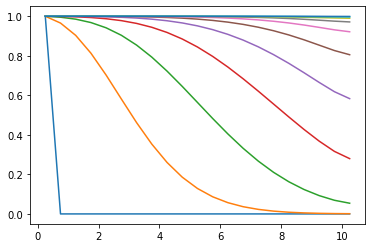

In [16]:
x = mf.dis.sr.xcenter
for t in range(0, len(times)):
    y = conc[t, 0, 0, :]
    plt.plot(x, y)

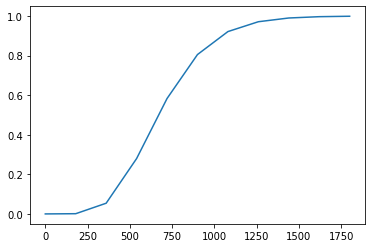

In [17]:
C_btc = conc[:, 0, 0, -1]
plt.plot(times, C_btc, label='Breakthrough Curve')

## Activity:
Interpret these plots. Label the axis and describe what they are showing. From the plots do these look like a continous injection/source or pulse/finite length plume?

As set up, these models are difficult to re-run with different parameters. In the next notebook we will structure these models into functions.